# PyCUDA_multiplicar_sumar_elementos



## Instalación de la librería

In [1]:
!pip install pycuda

## Importando las librerías

In [2]:
# Para inicializar automáticamente PyCUDA y la GPU
import pycuda.autoinit

# Para interactuar directamente con el controlador de la GPU
import pycuda.driver as drv

# Para manipular arrays y operaciones en la CPU
import numpy as np

# Para compilar y cargar módulos CUDA en la GPU
from pycuda.compiler import SourceModule

# Para medir los tiempos
import time

# Para generar gráficos
import matplotlib.pyplot as plt

## Verificación de los recursos de GPU

In [3]:
drv.init()
print("%d dispositivo(s) encontrado." % drv.Device.count())
for i in range(drv.Device.count()):
  dev = drv.Device(i)
  print("\n Dispositivo #%d: %s" % (i, dev.name()))
  print(" Memoria Total: %s GB" % (dev.total_memory() // (1024 * 1024 * 1024)))
  print(" Capacidad de Computación: %d.%d" % dev.compute_capability())

1 dispositivo(s) encontrado.

 Dispositivo #0: Tesla T4
 Memoria Total: 14 GB
 Capacidad de Computación: 7.5


## Ejemplo del uso de PyCUDA, multiplicación por número

In [4]:
# Establece la semilla para reproducibilidad
np.random.seed(42)

# Crea una matriz con números aleatorios enteros entre 0 y 10
a = np.random.randint(0, 11, size=(100, 100))

# Convierte la matriz a formato de punto flotante de 32 bits
a = a.astype(np.float32)

a

array([[ 6.,  3., 10., ...,  0., 10.,  4.],
       [ 9.,  6.,  9., ...,  4.,  0.,  0.],
       [ 2.,  1.,  4., ...,  6.,  2.,  0.],
       ...,
       [ 6.,  8.,  5., ...,  1.,  9.,  7.],
       [ 5.,  6.,  6., ...,  9.,  5.,  0.],
       [ 8.,  2.,  4., ...,  9.,  9.,  1.]], dtype=float32)

### GPU

In [5]:
# Asigna memoria en la GPU para la matriz
a_gpu = drv.mem_alloc(a.nbytes)

# Copia los datos de la matriz de la memoria del host a la memoria de la GPU
drv.memcpy_htod(a_gpu, a)

# Define un módulo de código CUDA
mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] *= 2;
  }
  """)

# Obtiene la función 'doublify' del módulo CUDA
func = mod.get_function("doublify")

# Inicia el tiempo de medición para la operación CUDA
start_time_cuda = time.time()

# Ejecuta la función 'doublify' en un bloque de 4x4 hilos
func(a_gpu, block=(4,4,1))

# Crea una matriz vacía con la misma forma y tipo que la matriz 'a'
a_doubled = np.empty_like(a)

# Copia los datos de la matriz procesada desde la memoria de la GPU al host
drv.memcpy_dtoh(a_doubled, a_gpu)

# Detiene el tiempo de medición para la operación CUDA
end_time_cuda = time.time()
# Calcula el tiempo total de la operación CUDA
time_cuda = end_time_cuda - start_time_cuda

print("Tiempo de ejecución CUDA: ", time_cuda)

# Imprime la matriz procesada
print("Matriz procesada:\n")
print(a_doubled)

# Imprime la matriz original
print("Matriz original:\n")
print(a)

Tiempo de ejecución CUDA:  0.0011260509490966797
Matriz procesada:

[[12.  6. 20. ...  0. 10.  4.]
 [ 9.  6.  9. ...  4.  0.  0.]
 [ 2.  1.  4. ...  6.  2.  0.]
 ...
 [ 6.  8.  5. ...  1.  9.  7.]
 [ 5.  6.  6. ...  9.  5.  0.]
 [ 8.  2.  4. ...  9.  9.  1.]]
Matriz original:

[[ 6.  3. 10. ...  0. 10.  4.]
 [ 9.  6.  9. ...  4.  0.  0.]
 [ 2.  1.  4. ...  6.  2.  0.]
 ...
 [ 6.  8.  5. ...  1.  9.  7.]
 [ 5.  6.  6. ...  9.  5.  0.]
 [ 8.  2.  4. ...  9.  9.  1.]]


### CPU

In [6]:
# Inicia el tiempo de medición para la operación con bucle en cpu
start_time_cpu = time.time()

# Duplica cada elemento de la matriz utilizando un bucle for
a_doubled_python = np.empty_like(a)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        a_doubled_python[i, j] = a[i, j] * 2

# Detiene el tiempo de medición para la operación con bucle en Python
end_time_cpu = time.time()

# Calcula el tiempo total de la operación con bucle en Python
time_cpu= end_time_cpu - start_time_cpu

print("Tiempo de ejecución cpu: ", time_cpu)


Tiempo de ejecución cpu:  0.1401841640472412


### Comparación GPU vs CPU

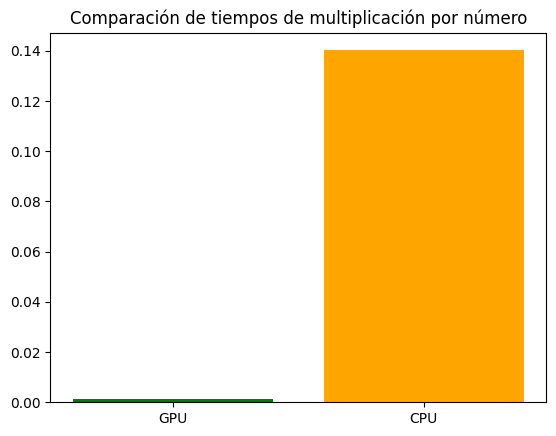

In [7]:
# Nombres de las operaciones
labels = ['GPU', 'CPU']

# Valores de tiempo
values = [time_cuda, time_cpu]

# Graficar en barras con escala logarítmica en el eje y
plt.bar(labels, values, color=['green', 'orange'])
plt.title('Comparación de tiempos de multiplicación por número')
plt.show()


## Suma de matrices

In [8]:
# Establece la semilla para reproducibilidad
np.random.seed(42)

# Crear dos matrices aleatorias
b = np.random.randint(0, 11, size=(100, 100)).astype(np.float32)
c = np.random.randint(0, 11, size=(100, 100)).astype(np.float32)

# Imprime las matrices originales
print("Matriz 'b':")
print(b)
print("\nMatriz 'c':")
print(c)

Matriz 'b':
[[ 6.  3. 10. ...  0. 10.  4.]
 [ 9.  6.  9. ...  4.  0.  0.]
 [ 2.  1.  4. ...  6.  2.  0.]
 ...
 [ 6.  8.  5. ...  1.  9.  7.]
 [ 5.  6.  6. ...  9.  5.  0.]
 [ 8.  2.  4. ...  9.  9.  1.]]

Matriz 'c':
[[ 0.  4.  0. ...  2. 10.  4.]
 [ 0.  2.  3. ...  4.  3.  9.]
 [ 4.  3.  2. ...  5.  6.  1.]
 ...
 [ 4.  6.  4. ...  2.  3.  9.]
 [ 5.  4.  2. ...  3.  1.  3.]
 [ 1.  0. 10. ...  7.  9.  6.]]


### GPU

In [9]:
# Definición del módulo de CUDA que contiene la función del kernel
mod2 = SourceModule("""
  __global__ void add2(float *a, float *b)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] += b[idx];
  }
  """)

# Asignar memoria en la GPU para las matrices
b_gpu = drv.mem_alloc(b.nbytes)
c_gpu = drv.mem_alloc(c.nbytes)

# Copiar los datos de las matrices al dispositivo (GPU)
drv.memcpy_htod(b_gpu, b)
drv.memcpy_htod(c_gpu, c)

# Obtener la función del kernel compilado
func = mod2.get_function("add2")

# Iniciar el cronómetro
start_time = time.time()

# Llamar a la función del kernel con las matrices como argumentos
func(b_gpu, c_gpu, block=(4,4,1))

# Crear un array vacío del mismo tamaño que b para almacenar el resultado
added = np.empty_like(b)

# Copiar los resultados desde la memoria de la GPU al array creado
drv.memcpy_dtoh(added, b_gpu)

# Parar el cronómetro
end_time = time.time()

# Calcular la duración
duration1 = end_time - start_time

# Imprimir los resultados
print("Matriz B:\n")
print(b)
print("Matriz C:\n")
print(c)
print("Resultado suma:\n")
print(added)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución: {:.6f} segundos".format(duration1))

Matriz B:

[[ 6.  3. 10. ...  0. 10.  4.]
 [ 9.  6.  9. ...  4.  0.  0.]
 [ 2.  1.  4. ...  6.  2.  0.]
 ...
 [ 6.  8.  5. ...  1.  9.  7.]
 [ 5.  6.  6. ...  9.  5.  0.]
 [ 8.  2.  4. ...  9.  9.  1.]]
Matriz C:

[[ 0.  4.  0. ...  2. 10.  4.]
 [ 0.  2.  3. ...  4.  3.  9.]
 [ 4.  3.  2. ...  5.  6.  1.]
 ...
 [ 4.  6.  4. ...  2.  3.  9.]
 [ 5.  4.  2. ...  3.  1.  3.]
 [ 1.  0. 10. ...  7.  9.  6.]]
Resultado suma:

[[ 6.  7. 10. ...  0. 10.  4.]
 [ 9.  6.  9. ...  4.  0.  0.]
 [ 2.  1.  4. ...  6.  2.  0.]
 ...
 [ 6.  8.  5. ...  1.  9.  7.]
 [ 5.  6.  6. ...  9.  5.  0.]
 [ 8.  2.  4. ...  9.  9.  1.]]
Tiempo de ejecución: 0.000360 segundos


### CPU

In [10]:
# Iniciar el cronómetro
start_time = time.time()

# Crear un array vacío del mismo tamaño que b para almacenar el resultado
added = np.empty_like(b)

# Realizar la suma elemento a elemento
for i in range(b.shape[0]):
    for j in range(b.shape[1]):
        added[i, j] = b[i, j] + c[i, j]

# Parar el cronómetro
end_time = time.time()

# Calcular la duración
duration2 = end_time - start_time

# Imprimir los resultados
print("Matriz B:\n", b)
print("Matriz C:\n", c)
print("Resultado suma:\n", added)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución en CPU: {:.6f} segundos".format(duration2))

Matriz B:
 [[ 6.  3. 10. ...  0. 10.  4.]
 [ 9.  6.  9. ...  4.  0.  0.]
 [ 2.  1.  4. ...  6.  2.  0.]
 ...
 [ 6.  8.  5. ...  1.  9.  7.]
 [ 5.  6.  6. ...  9.  5.  0.]
 [ 8.  2.  4. ...  9.  9.  1.]]
Matriz C:
 [[ 0.  4.  0. ...  2. 10.  4.]
 [ 0.  2.  3. ...  4.  3.  9.]
 [ 4.  3.  2. ...  5.  6.  1.]
 ...
 [ 4.  6.  4. ...  2.  3.  9.]
 [ 5.  4.  2. ...  3.  1.  3.]
 [ 1.  0. 10. ...  7.  9.  6.]]
Resultado suma:
 [[ 6.  7. 10. ...  2. 20.  8.]
 [ 9.  8. 12. ...  8.  3.  9.]
 [ 6.  4.  6. ... 11.  8.  1.]
 ...
 [10. 14.  9. ...  3. 12. 16.]
 [10. 10.  8. ... 12.  6.  3.]
 [ 9.  2. 14. ... 16. 18.  7.]]
Tiempo de ejecución en CPU: 0.015972 segundos


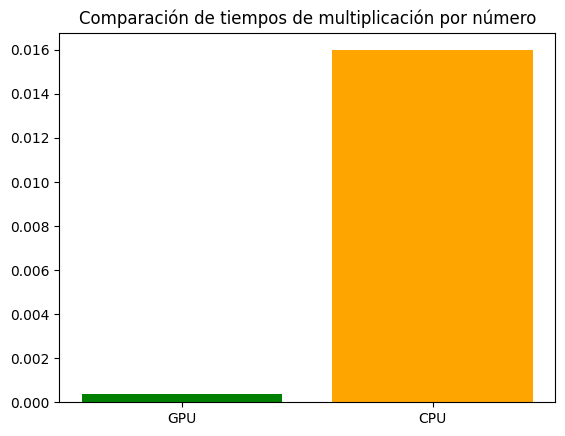

In [11]:
# Nombres de las operaciones
labels = ['GPU', 'CPU']

# Valores de tiempo
values = [duration1, duration2]

# Graficar en barras con escala logarítmica en el eje y
plt.bar(labels, values, color=['green', 'orange'])
plt.title('Comparación de tiempos de multiplicación por número')
plt.show()
